# Installing dependencies

In [2]:
%pip install tensorflow-io

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install tensorflow_io

Note: you may need to restart the kernel to use updated packages.


In [9]:
%pip uninstall tensorflow keras -y

Found existing installation: tensorflow 2.11.0
Uninstalling tensorflow-2.11.0:
  Successfully uninstalled tensorflow-2.11.0
Found existing installation: keras 2.11.0
Uninstalling keras-2.11.0:
  Successfully uninstalled keras-2.11.0
Note: you may need to restart the kernel to use updated packages.


In [10]:
%pip install tensorflow==2.11

^C
Note: you may need to restart the kernel to use updated packages.


  Using cached tensorflow-2.11.0-cp310-cp310-win_amd64.whl.metadata (2.5 kB)
  Using cached keras-2.11.0-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached tensorflow-2.11.0-cp310-cp310-win_amd64.whl (1.9 kB)
Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)


## loading dependencies

In [94]:
import os 
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

### Steps in the project
1. convert audio data to waveform
2. Transform waveform to spectrogram
3. classify capuchin bird calls 

### Data Loading function

In [96]:
def load_wav_16k_mono(filename):
    # Load encoded .wav file which is the audio file 
    file_contents = tf.io.read_file(filename)
    
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    
    # wav = resample_tensor(wav, rate_in=sample_rate, rate_out=16000) -- using only tensorflow
    
    return wav

### Plot Wave

In [98]:
CAPUCHIN_FILE = os.path.join('dl_data', 'Parsed_Capuchinbird_Clips', 'XC3776-1.wav')
NOT_CAPUCHIN_FILE = os.path.join('dl_data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-1.wav')

In [99]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

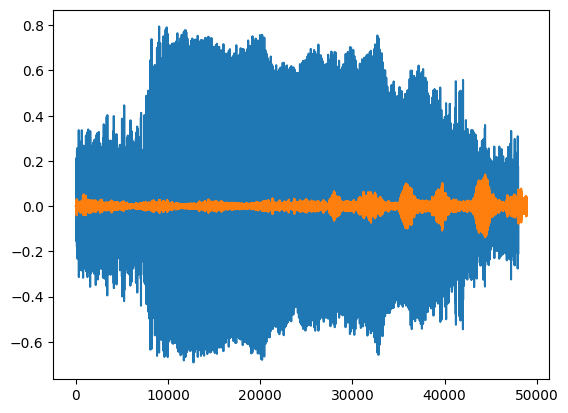

In [100]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

Blue wave is capuchin bird call and yellow is not capuchin bird call

### Create tensorflow dataset

define paths to positive and negative data

In [101]:
POS = os.path.join('dl_data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('dl_data', 'Parsed_Not_Capuchinbird_Clips')

this tensorflow function convert files to string of files makes it easy to process and load them

In [103]:
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

Adding label and combine positive and negative samples

In [104]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

### Determine average length of capuchin calls

Calculate wave cycle length the capuchin bird call we are calculating these lengths to get better result

In [105]:
lengths = []
for file in os.listdir(os.path.join('dl_data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('dl_data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

After getting all the lengths of the capuchin bird calls now we need to calculate the mean , min , max of these lengths

In [106]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [35]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [36]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

### Building preprocessing function to convert to Spectorgram

#### Preprocessing function

In [109]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    # short time fourier transform analog signal to discrete 
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

#### Test out this Function

In [116]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [117]:
spectrogram, label = preprocess(filepath, label)

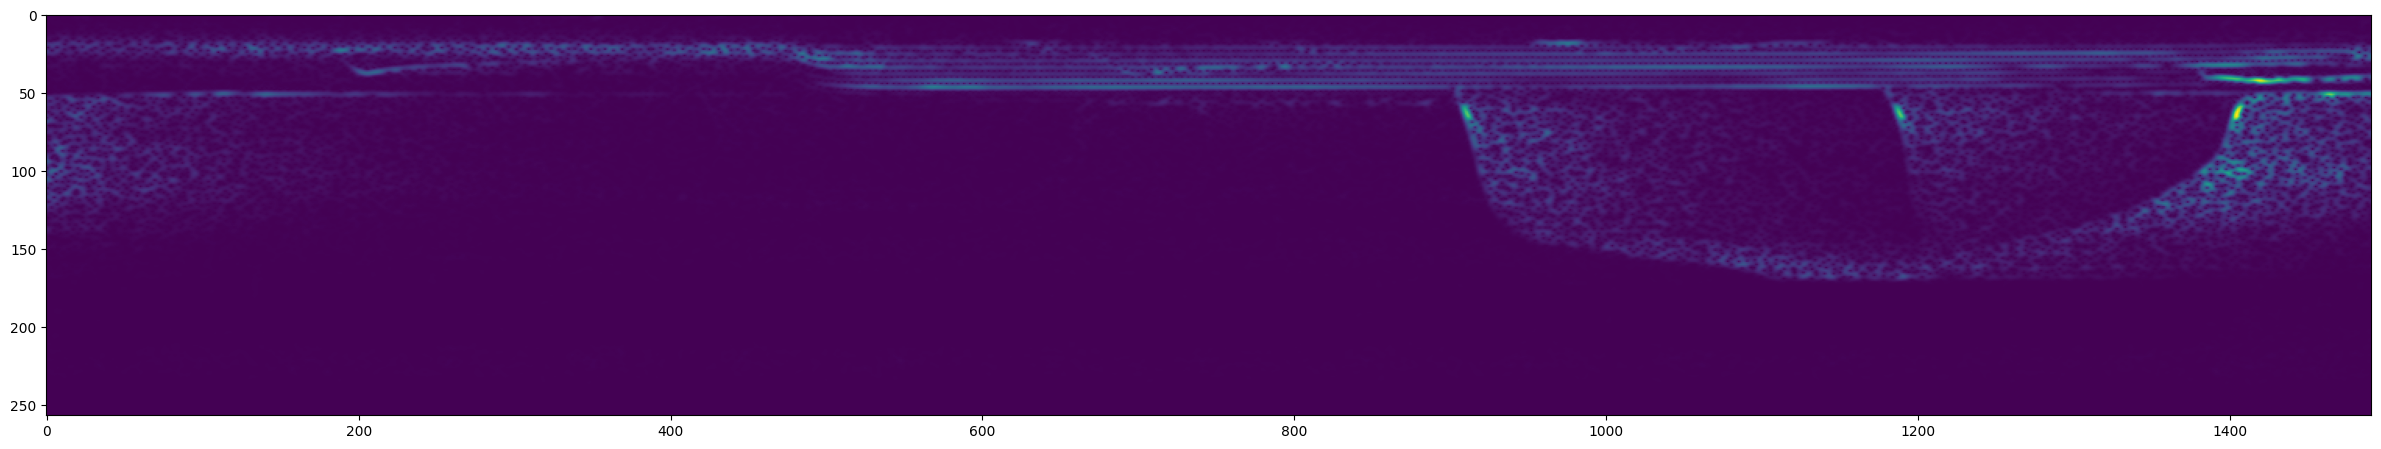

In [118]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

## Building a Deep Learning model

### Create tensorflow data 

In [119]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

### Split data into training and testing

In [124]:
len(data)

51

In [125]:
train = data.take(36)          #70%
test = data.skip(36).take(15)  #30%

Test one batch

In [126]:
samples, labels = train.as_numpy_iterator().next()

In [127]:
samples.shape

(16, 1491, 257, 1)

(examples , shape)

### Deep Learning model

In [128]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [129]:
# model = Sequential()
# model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
# model.add(Conv2D(16, (3,3), activation='relu'))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

model = Sequential()
model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(1491, 257, 1)))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


we are using Adam optimizer , loss function to reduce is Binary Cross Entropy

In [130]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [133]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 1489, 255, 8)      80        
                                                                 
 conv2d_3 (Conv2D)           (None, 1487, 253, 8)      584       
                                                                 
 flatten_1 (Flatten)         (None, 3009688)           0         
                                                                 
 dense_2 (Dense)             (None, 32)                96310048  
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 96,310,745
Trainable params: 96,310,745
Non-trainable params: 0
_________________________________________________________________


In [135]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [138]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4


36/36 [==============================] - 1149s 32s/step - loss: 0.1254 - recall_1: 0.9484 - precision_1: 0.9735 - val_loss: 0.0156 - val_recall_1: 1.0000 - val_precision_1: 0.9851
Epoch 2/4
36/36 [==============================] - 1050s 29s/step - loss: 0.0723 - recall_1: 0.9868 - precision_1: 0.9868 - val_loss: 0.0108 - val_recall_1: 0.9818 - val_precision_1: 1.0000
Epoch 3/4
36/36 [==============================] - 1061s 30s/step - loss: 0.0069 - recall_1: 1.0000 - precision_1: 1.0000 - val_loss: 0.0153 - val_recall_1: 0.9846 - val_precision_1: 1.0000
Epoch 4/4
36/36 [==============================] - 3177s 90s/step - loss: 0.0116 - recall_1: 0.9937 - precision_1: 1.0000 - val_loss: 0.0180 - val_recall_1: 0.9683 - val_precision_1: 1.0000


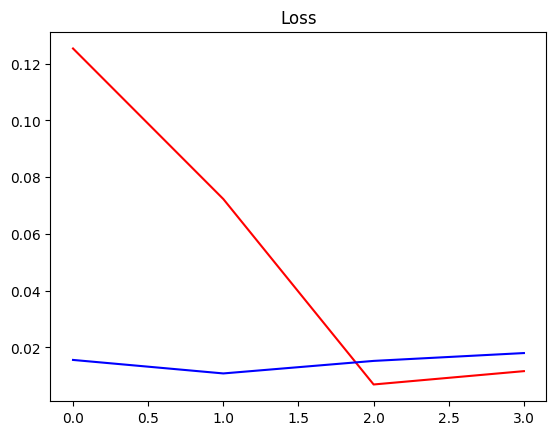

In [144]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

## Make Prediction on Single Clip

Get one Batch and make a prediction

In [147]:
X_test, y_test = test.as_numpy_iterator().next()

In [148]:
yhat = model.predict(X_test)

1/1 [==============================] - 4s 4s/step


#### Putting predictions to Classes

In [149]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

# this code
# yhat = []
# for prediction in yhat:
#     if prediction > 0.5:
#         yhat.append(1)
#     else:
#         yhat.append(0)

In [150]:
yhat

[0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]

## Building Forset parsing function

#### Loading mp3 

In [151]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [152]:
mp3 = os.path.join('dl_data', 'Forest Recordings', 'recording_00.mp3')

In [153]:
wav = load_mp3_16k_mono(mp3)

Slicing the clip into same size audio slices for predictions

In [154]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [155]:
#to get number of audio slices
len(audio_slices)

60

In [156]:
samples, index = audio_slices.as_numpy_iterator().next()

### Function to convert clips into spectrogram

In [157]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

### Convert Longer clips into windows and Make predictions

In [158]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [159]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

3/3 [==============================] - 43s 14s/step


### Group consecutive detection

In [160]:
from itertools import groupby

In [161]:
yhat = [key for key, group in groupby(yhat)]
#adding all the calls in the clip
calls = tf.math.reduce_sum(yhat).numpy()

In [162]:
calls

5

### Loop over all the recordings and make predictions

In [163]:
results = {}
for file in os.listdir(os.path.join('dl_data', 'Forest Recordings')):
    FILEPATH = os.path.join('dl_data','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

1/1 [==============================] - 17s 17s/step


In [164]:
results

{'recording_00.mp3': array([[8.9693e-04],
        [1.0204e-03],
        [2.9564e-03],
        [9.9658e-01],
        [1.0000e+00],
        [8.0061e-04],
        [5.7459e-04],
        [4.6945e-04],
        [1.7822e-04],
        [1.3103e-03],
        [7.6389e-04],
        [6.4850e-04],
        [1.7538e-03],
        [1.0000e+00],
        [1.0000e+00],
        [5.8603e-04],
        [5.9605e-08],
        [4.9543e-04],
        [2.3060e-03],
        [3.0518e-03],
        [2.4090e-03],
        [1.1034e-03],
        [4.0703e-03],
        [6.6064e-01],
        [1.0000e+00],
        [7.9441e-04],
        [1.1963e-04],
        [1.0986e-03],
        [4.9543e-04],
        [1.3103e-03],
        [6.9857e-04],
        [1.8101e-03],
        [2.2471e-05],
        [9.8348e-06],
        [2.1496e-03],
        [9.8896e-04],
        [1.0000e+00],
        [3.7372e-05],
        [7.5483e-04],
        [6.0768e-03],
        [7.4053e-04],
        [3.8910e-04],
        [1.7881e-03],
        [9.0361e-04],
        [6.0

### Convert Predictions into classes

In [165]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_00.mp3': [0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  

### Group the consecutive detections

In [166]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 4,
 'recording_05.mp3': 0,
 'recording_06.mp3': 5,
 'recording_07.mp3': 2,
 'recording_08.mp3': 24,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 2,
 'recording_12.mp3': 0,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 2,
 'recording_16.mp3': 5,
 'recording_17.mp3': 3,
 'recording_18.mp3': 5,
 'recording_19.mp3': 0,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 5,
 'recording_24.mp3': 0,
 'recording_25.mp3': 12,
 'recording_26.mp3': 2,
 'recording_27.mp3': 0,
 'recording_28.mp3': 14,
 'recording_29.mp3': 0,
 'recording_30.mp3': 3,
 'recording_31.mp3': 1,
 'recording_32.mp3': 2,
 'recording_33.mp3': 0,
 'recording_34.mp3': 4,
 'recording_35.mp3': 0,
 'recording_36.mp3': 0,
 'recording_37.mp3': 3,
 'recording_38.mp3': 1,
 'recording_39.mp3': 4,
 'recording_40.mp3': 1,
 'recording_4

### Export Results

In [167]:
import csv

In [168]:
with open('lab_evaluation_result.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])

Saving the Model

Loading the saved model

In [169]:
# Load the saved model
model = load_model('capuchin_model.h5')

In [90]:
testAudio = os.path.join('dl_data','Parsed_Capuchinbird_Clips','XC3776-3.wav')

In [91]:
wav = load_wav_16k_mono(testAudio)

In [92]:
input_tensor = tf.expand_dims(wav, axis=0)